In [1]:
import numpy as np
import torch 
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms,utils

In [2]:
import numpy
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(22)

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.
                               transforms.Normalize(mean=[0.5],std=[0.5])])
train_data = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)

test_data = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

In [4]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,
                                          shuffle=True)

print(len(train_loader), len(test_loader))

938 157


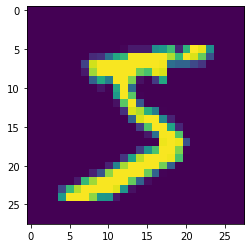

In [5]:
oneimg,label = train_data[0]
oneimg = oneimg.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
oneimg = oneimg * std + mean
oneimg.resize(28,28)
plt.imshow(oneimg)
plt.show()

In [6]:
import torch.nn.functional as F
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, 5, stride=1, padding=2), # batch x 4 x 28 x 28
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True), # batch x 4 x 14 x 14
        )

        self.unpool = nn.MaxUnpool2d(2, stride=2, padding=0)

        self.decoder = nn.Sequential( 
            # nn.ConvTranspose2d(4, 4, 2, stride=1, padding=0), 
            nn.ReLU(),
            nn.BatchNorm2d(4),
            nn.ConvTranspose2d(4, 1, 5, stride=1, padding=2, output_padding=0), 
            nn.ReLU(),
        )

        # self.reg = nn.Parameter(torch.Tensor[0.5])s
        self.pos_mlp = nn.Sequential(nn.Linear(784, 128), nn.BatchNorm1d(128), nn.Dropout(), nn.Linear(128, 11))
        
        self.reset_parameters()
    
    def reset_parameters(self):
        for conv in self.encoder:
            if isinstance(conv, nn.Conv2d):
                nn.init.xavier_normal_(conv.weight.data)
        for conv in self.decoder:
            if isinstance(conv, nn.Conv2d):
                nn.init.xavier_normal_(conv.weight.data)
        for layer in self.pos_mlp:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight.data)
                nn.init.zeros_(layer.bias.data)
        
    def forward(self, x):
        encoded_x, indices = self.encoder(x)
        decoded_x = self.unpool(encoded_x, indices)
        encoded_x = self.pos_mlp(encoded_x.view(x.shape[0], -1))
        decoded_x = self.decoder(decoded_x)
        # print(decoded_x.shape)
        return decoded_x, encoded_x

net = AutoEncoder()        

In [7]:
import torch.optim as optim

criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)   
reg = 2e-3

In [8]:
train_accs = []
train_loss = []
test_accs = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
for epoch in range(10):
    running_loss = 0.0
    for i,data in enumerate(train_loader,0):#0是下标起始位置默认为0
        inputs,labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()         
        
        decoded_x, encoded_x = net(inputs)
        loss = criterion1(encoded_x, labels) + reg * criterion2(decoded_x, inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i%100 == 99:
            print('[%d,%5d] loss :%.3f' %
                 (epoch+1,i+1,running_loss/100))
            running_loss = 0.0
        train_loss.append(loss.item())
        
        correct = 0
        total = 0
        _, predicted = torch.max(encoded_x.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        train_accs.append(100*correct/total)
        
print('Finished Training')            

[1,  100] loss :0.460
[1,  200] loss :0.219
[1,  300] loss :0.199
[1,  400] loss :0.170
[1,  500] loss :0.177
[1,  600] loss :0.159
[1,  700] loss :0.135
[1,  800] loss :0.142
[1,  900] loss :0.137
[2,  100] loss :0.120
[2,  200] loss :0.118
[2,  300] loss :0.141
[2,  400] loss :0.127
[2,  500] loss :0.114
[2,  600] loss :0.116
[2,  700] loss :0.119
[2,  800] loss :0.119
[2,  900] loss :0.117
[3,  100] loss :0.092
[3,  200] loss :0.108
[3,  300] loss :0.097
[3,  400] loss :0.106
[3,  500] loss :0.099
[3,  600] loss :0.104
[3,  700] loss :0.106
[3,  800] loss :0.107
[3,  900] loss :0.091
Finished Training


In [9]:
def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("acc(\%)", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

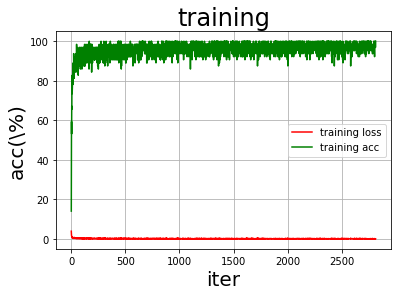

In [10]:
train_iters = range(len(train_accs))
draw_train_process('training',train_iters,train_loss,train_accs,'training loss','training acc')

In [11]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [12]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

In [13]:
test_net = AutoEncoder()
test_net.load_state_dict(torch.load(PATH))
test_out = test_net(images)

In [14]:
correct = 0
total = 0
with torch.no_grad():# 进行评测的时候网络不更新梯度
    for data in test_loader:
        images, labels = data
        _, outputs = test_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)# labels 的长度
        correct += (predicted == labels).sum().item() # 预测正确的数目

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the  test images: 96 %


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        _, outputs = test_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
#         print(predicted == labels)
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %d : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 100 %
Accuracy of 1 : 99 %
Accuracy of 2 : 96 %
Accuracy of 3 : 99 %
Accuracy of 4 : 97 %
Accuracy of 5 : 99 %
Accuracy of 6 : 97 %
Accuracy of 7 : 97 %
Accuracy of 8 : 98 %
Accuracy of 9 : 96 %
